In [190]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv
/kaggle/input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv
/kaggle/input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv
/kaggle/input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv
/kaggle/input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Colombia - Cementos Argos SA (CCB).csv
/kaggle/input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv
/kaggle/input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv
/kaggle/input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv
/kaggle/input/stockmae/StockMAE.csv


In [191]:
import glob
import warnings
warnings.filterwarnings("ignore")

In [192]:
# idetify if data has null value and delete null value
def hasnull(df):
    for idx,col in df.items():
        if col.isna().sum == 0:
            pass
        else: 
            df = df[df.isnull().any(axis=1) == False]
        return df


In [193]:
#convert str type to float type 
def covertype(df):
    df['Price'] = df['Price'].str.replace(',','').astype('float')
    df['Open'] =  df['Open'].str.replace(',','').astype('float')
    df['High'] =  df['High'].str.replace(',','').astype('float')
    df['Low'] =   df['Low'].str.replace(',','').astype('float')
    return df

In [194]:
#remove'M'or'k'or '%'from column Vol.
def removeMK(df,col1,col2):
    df[col1] = df[col1].str.strip('%').astype('float')/100
    df = df[df[col2].str.contains('-') == False]
    df = df.reset_index(drop=True)
    for i, value in enumerate(df[col2]):
#         print(i,value)
        if value[-1] == "K":
            df[col2][i] = float(value[:-1]) * 1000
        elif value[-1] == "M":
            df[col2][i] = float(value[:-1]) * 1000 * 1000
    return df
        

In [195]:
#change Column DATE type to datatime type
def dateclean(df,col):
    df[col] =  df[col].str.replace('Jan','January')
    df[col] =  df[col].str.replace('Feb','February')
    df[col] =  df[col].str.replace('Mar','March')
    df[col] =  df[col].str.replace('Apr','April')
    df[col] =  df[col].str.replace('Jun','June')
    df[col] =  df[col].str.replace('Jul','July')
    df[col] =  df[col].str.replace('Aug','August')
    df[col] =  df[col].str.replace('Sep','September')
    df[col] =  df[col].str.replace('Oct','October')
    df[col] =  df[col].str.replace('Nov','November')
    df[col] =  df[col].str.replace('Dec','December')
    df = df.iloc[::-1]
    return df

In [196]:
from datetime import datetime
def str_to_datetime(s):
    s = datetime.strptime(s, '%B %d, %Y')
    s = s.strftime('%Y-%m-%d')
    s = datetime.strptime(s,'%Y-%m-%d')
    return s 

In [197]:
from sklearn import preprocessing,svm
# Split data to train data and test data
def splitdata_svm(df,col1):
    df = df.set_index(col1)
    df_train = df['2020-01-02':'2020-12-30']
    df_test = df['2021-01-04':'2021-03-31']
    
    df_train['label'] = df_train['Price'].shift(-1) # shift next day price 
    df_train.drop(df_train.index[-1],inplace=True)

    df_test['label'] = df_test['Price'].shift(-1)
    df_test.drop(df_test.index[-1],inplace=True)
    
    y_train = np.array(df_train['label'])
    x_train = np.array(df_train.drop(['label'],1))
    x_train = preprocessing.scale(x_train)


    y_test = np.array(df_test['label'])
    x_test = np.array(df_test.drop(['label'],1))
    x_test = preprocessing.scale(x_test)

    
    return df_train,df_test,x_train,y_train,x_test,y_test

In [198]:
from sklearn import svm
from sklearn.metrics import mean_absolute_error
# predcit 2021Q1 Stock price
def predict_svm(x_train,y_train,x_test,y_test,df_test):
    clf=svm.SVR()
    fold_model = clf.fit(x_train,y_train)
    predictions = fold_model.predict(x_test)
    fc_series = pd.Series(predictions)
    predcition_1 = fc_series[:1]
    predcition_5 = fc_series[:5]
    predcition_20 = fc_series[:20]
    test_1 = df_test.iloc[:1,-1:]
    test_5 = df_test.iloc[:5,-1:]
    test_20 = df_test.iloc[:20,-1:]
    mae_SVM_daily = mean_absolute_error(test_1,predcition_1)
    mae_SVM_weekly = mean_absolute_error(test_5,predcition_5)
    mae_SVM_monthly = mean_absolute_error(test_20,predcition_20)
    print('SVM_daily MAE:{:.3f}'.format(mae_SVM_daily))
    print('SVM_weekly MAE:{:.3f}'.format(mae_SVM_weekly))
    print('SVM_monthlyMAE:{:.3f}'.format(mae_SVM_monthly))

# Forecast stock price with SVM 

In [199]:
PATH = '../input/valueinvestor/Vauleinvestor' 
csv_files = glob.glob(os.path.join(PATH, "*.csv"))

In [200]:
for f in csv_files:
      
    # read the csv file
    df_orig = pd.read_csv(f)
      
    # print the location and filename
    print('File Name:', f.split("\\")[-1])
      
    # print the content
    print('Content:')
    display(df_orig)
    
    data = hasnull(df_orig)
    data = covertype(data)
    data = removeMK(data,'Change %','Vol.')
    data = dateclean(data,'Date')
    data['Date'] = data['Date'].apply(str_to_datetime)
    data_train,data_test,x_train,y_train,x_test,y_test = splitdata_svm(data,'Date')
    predict_svm(x_train,y_train,x_test,y_test,data_test)
    print('=====================================================================================================')
    print('=====================================================================================================')




File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv
Content:


,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",291.02,294,294.42,290.26,47.00M,-0.76%
1,"Mar 30, 2021",293.25,294.86,295.72,291.5,38.81M,-0.02%
2,"Mar 29, 2021",293.3,289.72,294.09,289.26,43.68M,0.71%
3,"Mar 26, 2021",291.22,288.63,292.75,288.32,56.07M,1.59%
4,"Mar 25, 2021",286.66,286.5,287.03,283.85,35.22M,0.30%
...,...,...,...,...,...,...,...
307,"Jan 09, 2020",257.99,259.4,261.76,257.01,38.33M,-0.45%
308,"Jan 08, 2020",259.15,253.57,259.15,253.03,40.82M,2.07%
309,"Jan 06, 2020",253.9,254.75,254.84,251.4,22.35M,-0.43%
310,"Jan 03, 2020",255,255.99,258.19,253.7,35.85M,0.10%


SVM_daily MAE:60.464
SVM_weekly MAE:58.991
SVM_monthlyMAE:51.972
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv
Content:


,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021","13,650","13,700","13,750","13,450",0.19K,0.00%
1,"Mar 30, 2021","13,650","13,850","14,200","13,050",3.17M,0.74%
2,"Mar 29, 2021","13,550","12,500","13,800","12,500",0.20K,11.07%
3,"Mar 28, 2021","12,200","12,200","12,200","12,200",-,0.00%
4,"Mar 26, 2021","12,200","11,500","12,300","11,350",2.34M,7.96%
...,...,...,...,...,...,...,...
337,"Jan 07, 2020","5,690","5,740","5,770","5,650",303.89K,-0.70%
338,"Jan 06, 2020","5,730","5,890","5,890","5,680",319.88K,-2.88%
339,"Jan 03, 2020","5,900","5,870","5,920","5,830",230.40K,0.85%
340,"Jan 02, 2020","5,850","5,930","5,980","5,820",239.90K,-1.68%


SVM_daily MAE:3279.491
SVM_weekly MAE:3246.923
SVM_monthlyMAE:2847.967
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv
Content:


,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",19.41,19.42,19.63,19.27,13.14M,-0.46%
1,"Mar 30, 2021",19.5,19.12,19.81,19.03,21.05M,2.09%
2,"Mar 29, 2021",19.1,19.24,19.67,19.1,16.56M,-0.78%
3,"Mar 26, 2021",19.25,20.28,20.36,19.1,21.35M,-3.85%
4,"Mar 25, 2021",20.02,20.5,20.86,20.02,15.93M,-1.48%
...,...,...,...,...,...,...,...
311,"Jan 07, 2020",19.93,20.22,20.28,19.92,2.89M,-0.75%
312,"Jan 06, 2020",20.08,20.34,20.34,19.97,1.94M,-1.08%
313,"Jan 03, 2020",20.3,20.3,20.44,19.97,3.31M,-0.39%
314,"Jan 02, 2020",20.38,20.42,20.44,20.24,2.53M,0.30%


SVM_daily MAE:5.664
SVM_weekly MAE:5.929
SVM_monthlyMAE:5.430
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv
Content:


,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",3.75,3.74,3.82,3.71,1.57M,0.54%
1,"Mar 30, 2021",3.73,3.71,3.76,3.67,3.43M,0.81%
2,"Mar 29, 2021",3.7,3.69,3.73,3.68,1.25M,-0.27%
3,"Mar 28, 2021",3.71,3.76,3.76,3.68,2.34M,0.00%
4,"Mar 25, 2021",3.71,3.62,3.78,3.59,2.50M,1.37%
...,...,...,...,...,...,...,...
301,"Jan 08, 2020",4.41,4.19,4.59,4.15,3.52M,3.04%
302,"Jan 06, 2020",4.28,4.16,4.44,4.12,2.52M,-2.95%
303,"Jan 05, 2020",4.41,4.7,4.7,4.33,3.76M,-8.32%
304,"Jan 02, 2020",4.81,4.81,4.87,4.78,241.60K,-0.21%


SVM_daily MAE:0.081
SVM_weekly MAE:0.041
SVM_monthlyMAE:0.111
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Colombia - Cementos Argos SA (CCB).csv
Content:


,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021","5,150.00","5,100.00","5,170.00","5,100.00",212.44K,0.98%
1,"Mar 30, 2021","5,100.00","5,010.00","5,100.00","5,010.00",583.70K,1.09%
2,"Mar 29, 2021","5,045.00","5,020.00","5,045.00","5,015.00",117.54K,0.50%
3,"Mar 26, 2021","5,020.00","5,085.00","5,085.00","4,980.00",203.46K,-0.20%
4,"Mar 25, 2021","5,030.00","5,035.00","5,045.00","4,950.00",317.06K,0.10%
...,...,...,...,...,...,...,...
299,"Jan 08, 2020","6,880.00","6,940.00","6,950.00","6,880.00",84.93K,-1.01%
300,"Jan 07, 2020","6,950.00","6,950.00","6,950.00","6,850.00",168.71K,-0.71%
301,"Jan 03, 2020","7,000.00","7,040.00","7,100.00","6,960.00",470.77K,-1.69%
302,"Jan 02, 2020","7,120.00","7,300.00","7,300.00","7,120.00",138.96K,-2.47%


SVM_daily MAE:1251.282
SVM_weekly MAE:1249.972
SVM_monthlyMAE:1282.502
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv
Content:


,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",10.2,10.35,10.4,10.12,7.77M,-1.54%
1,"Mar 30, 2021",10.36,10.41,10.62,10.3,9.93M,-1.05%
2,"Mar 29, 2021",10.47,9.85,10.5,9.81,22.04M,6.51%
3,"Mar 26, 2021",9.83,9.8,9.94,9.7,5.11M,0.31%
4,"Mar 25, 2021",9.8,10.01,10.01,9.66,8.88M,-1.51%
...,...,...,...,...,...,...,...
305,"Jan 07, 2020",13.48,13.03,13.48,13.03,8.20M,4.58%
306,"Jan 06, 2020",12.89,12.9,12.91,12.57,4.17M,-0.08%
307,"Jan 03, 2020",12.9,12.45,12.93,12.27,4.88M,2.63%
308,"Jan 02, 2020",12.57,12.88,12.99,12.57,5.78M,-2.10%


SVM_daily MAE:4.261
SVM_weekly MAE:3.030
SVM_monthlyMAE:2.044
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv
Content:


,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",85.15,86.5,88.1,85.15,564.30K,-1.10%
1,"Mar 30, 2021",86.1,85.15,86.75,84.6,141.40K,1.29%
2,"Mar 29, 2021",85,80,86,79,371.22K,3.85%
3,"Mar 26, 2021",81.85,84,84.6,80.7,462.55K,-2.09%
4,"Mar 25, 2021",83.6,85.2,87.3,82.1,389.78K,-3.13%
...,...,...,...,...,...,...,...
296,"Jan 07, 2020",47.6,48.35,49,46.9,901.95K,-1.86%
297,"Jan 06, 2020",48.5,48.4,48.7,47,719.24K,-0.61%
298,"Jan 03, 2020",48.8,48.25,49.45,46.5,595.36K,1.14%
299,"Jan 02, 2020",48.25,49.35,50.2,47.55,878.50K,-2.92%


SVM_daily MAE:36.549
SVM_weekly MAE:33.105
SVM_monthlyMAE:31.852
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv
Content:


,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021","27,373","26,980","27,526","26,657",2.49M,1.77%
1,"Mar 30, 2021","26,898","26,766","27,443","26,360",3.02M,-0.30%
2,"Mar 29, 2021","26,980","27,800","28,174","26,614",4.44M,-2.01%
3,"Mar 26, 2021","27,533","27,083","28,006","26,728",3.36M,3.65%
4,"Mar 25, 2021","26,564","25,954","27,128","25,954",2.83M,2.55%
...,...,...,...,...,...,...,...
310,"Jan 07, 2020","14,500","14,688","14,688","13,940",3.94M,-0.82%
311,"Jan 06, 2020","14,620","14,985","15,045","14,574",2.61M,-1.50%
312,"Jan 03, 2020","14,843","14,700","14,884","14,360",3.19M,3.58%
313,"Jan 02, 2020","14,330","14,525","14,764","14,325",2.01M,-0.15%


SVM_daily MAE:5677.539
SVM_weekly MAE:5871.544
SVM_monthlyMAE:6442.724


# Forecast stock price with LSTM

In [201]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
import math, time

In [202]:
def splitdata_LSTM(df):
    df = df[['Date','Price']]
    df.set_index('Date',inplace=True)
    df_train = df['2020-01-02':'2020-12-30']
    df_test = df['2021-01-04':'2021-03-31']
    
    return df,df_train,df_test

In [203]:
def load_data(stock,data_test,look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
   
    data = np.array(data);
    
    test_set_size = int(data_test.shape[0])
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    # make training and test sets in torch
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)
    
    return [x_train, y_train, x_test, y_test]

In [204]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
# print(model)
# print(len(list(model.parameters())))
# for i in range(len(list(model.parameters()))):
#     print(list(model.parameters())[i].size())

In [205]:
# Train model
def train(num_epochs,look_back,x_train,y_train):
    
    hist = np.zeros(num_epochs)
    # Number of steps to unroll
    seq_dim =look_back-1  

    for t in range(num_epochs):
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()

        # Forward pass
        y_train_pred = model(x_train)

        loss = loss_fn(y_train_pred, y_train)
#         if t % 10 == 0 and t !=0:
#             print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()

In [206]:
def predict_LSTM(x_test,df_test):
    y_test_pred = model(x_test)
    # # invert predictions
    y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
    fc_series = pd.Series(y_test_pred.reshape(-1))
#     print(fc_series)
    predcition_1 = fc_series[:1]
    predcition_5 = fc_series[:5]
    predcition_20 = fc_series[:20]
    test_1 = df_test.iloc[:1,-1:]
    test_5 = df_test.iloc[:5,-1:]
    test_20 = df_test.iloc[:20,-1:]
    mae_LSTM_daily = mean_absolute_error(test_1,predcition_1)
    mae_LSTM_weekly = mean_absolute_error(test_5,predcition_5)
    mae_LSTM_monthly = mean_absolute_error(test_20,predcition_20)
    print('LSTM_daily MAE:{:.3f}'.format(mae_LSTM_daily))
    print('LSTM_weekly MAE:{:.3f}'.format(mae_LSTM_weekly))
    print('LSTM_monthlyMAE:{:.3f}'.format(mae_LSTM_monthly))
    print('=====================================================================================================')
    print('=====================================================================================================')
    print('                                                                                                      ')
    print('                                                                                                      ')

In [207]:
for f in csv_files:
      
    # read the csv file
    df_orig = pd.read_csv(f)
      
    # print the location and filename
    print('File Name:', f.split("\\")[-1])
      
    # print the content
    print('Content:')
#     display(df_orig)
    
    data = hasnull(df_orig)
    data = covertype(data)
    data = removeMK(data,'Change %','Vol.')
    data = dateclean(data,'Date')
    data['Date'] = data['Date'].apply(str_to_datetime)
    data, data_train, data_test = splitdata_LSTM(data)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data['Price'] = scaler.fit_transform(data['Price'].values.reshape(-1,1))
    look_back = 5 # choose sequence length
    x_train, y_train, x_test, y_test = load_data(data,data_test,look_back)
    train(200,look_back,x_train,y_train)
    predict_LSTM(x_test,data_test)
   
    

File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv
Content:
LSTM_daily MAE:270.581
LSTM_weekly MAE:271.271
LSTM_monthlyMAE:273.767
                                                                                                      
                                                                                                      
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv
Content:
LSTM_daily MAE:7811.782
LSTM_weekly MAE:8430.732
LSTM_monthlyMAE:8658.852
                                                                                                      
                                                                                                      
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv
Content:
LSTM_daily MAE:20.459
LSTM_weekly MAE:20.547
LSTM_monthlyMAE:20.876
         

# Forecast stock price with ARIMA and SARIMA

In [208]:
!pip install pmdarima

In [209]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from pylab import mpl, plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

# ARIMA

In [210]:
def selectpdq(df_train):
    model_autoARIMA = auto_arima(df_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    print(model_autoARIMA.summary())
    model_autoARIMA.plot_diagnostics(figsize=(15,8))
    plt.show()

File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1499.638, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1501.228, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1501.180, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1497.685, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1502.372, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.252 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -747.842
Date:                Sat, 24 Sep 2022   AIC                           1497.685
Time:                        17:20:23   BIC                           1501.202
Sample:                             0   HQIC 

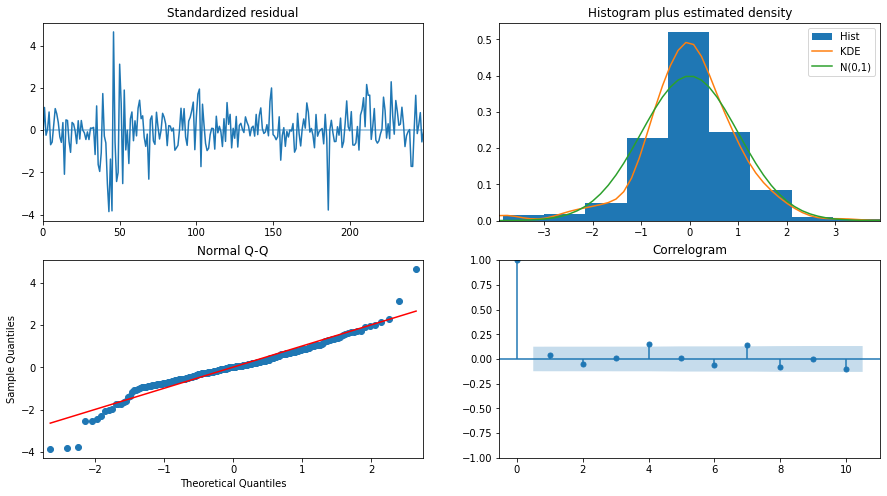

*****************************************************************************************************
*****************************************************************************************************
                                                                                                      
                                                                                                      
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3376.061, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3377.390, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3377.482, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3374.480, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3378.730, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.260 seconds
                 

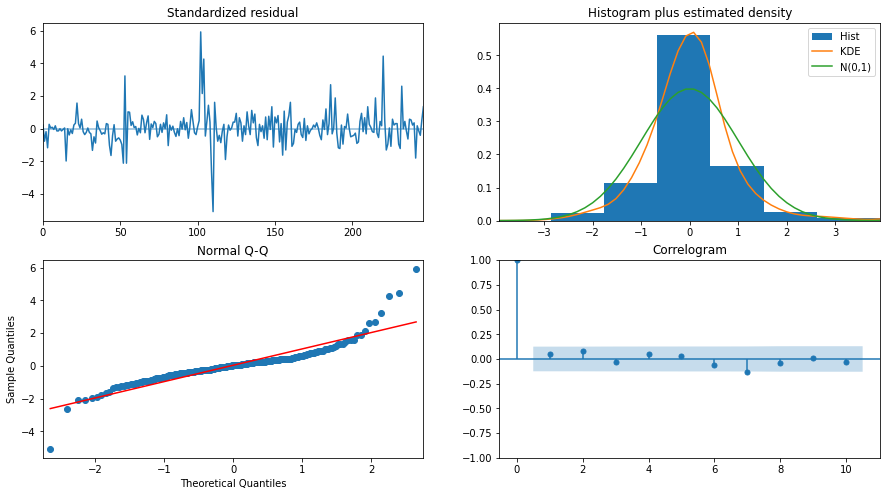

*****************************************************************************************************
*****************************************************************************************************
                                                                                                      
                                                                                                      
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=254.750, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=256.121, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=256.075, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=252.758, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=257.809, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.242 seconds
                               SARIMAX 

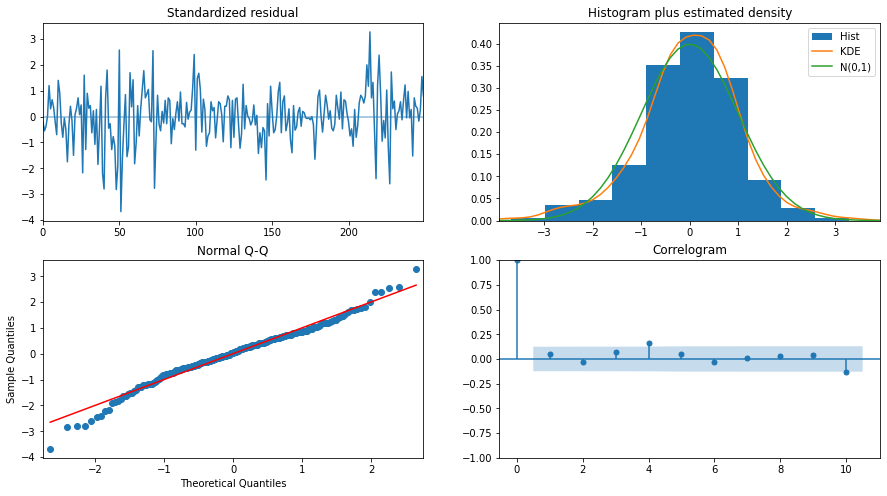

*****************************************************************************************************
*****************************************************************************************************
                                                                                                      
                                                                                                      
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-457.519, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-470.383, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-469.259, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-459.048, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-468.385, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-468.385, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC

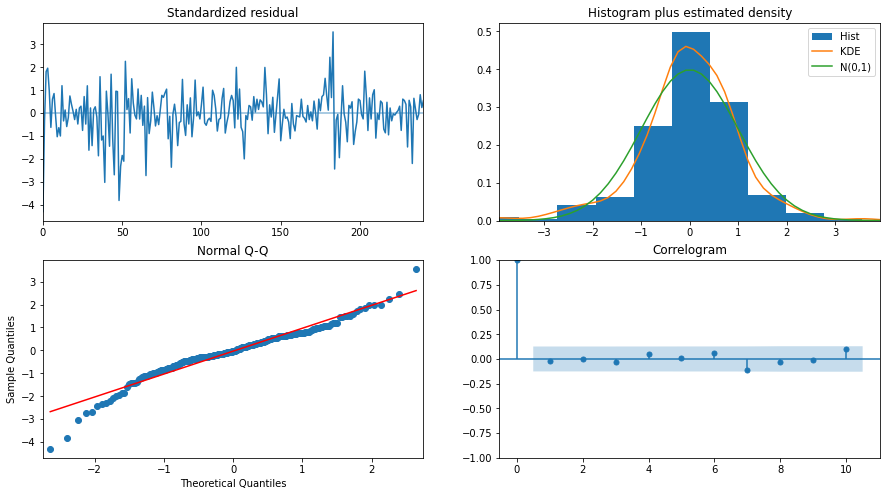

*****************************************************************************************************
*****************************************************************************************************
                                                                                                      
                                                                                                      
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Colombia - Cementos Argos SA (CCB).csv
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3134.781, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3135.412, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3135.672, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3132.924, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3135.191, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds
                               

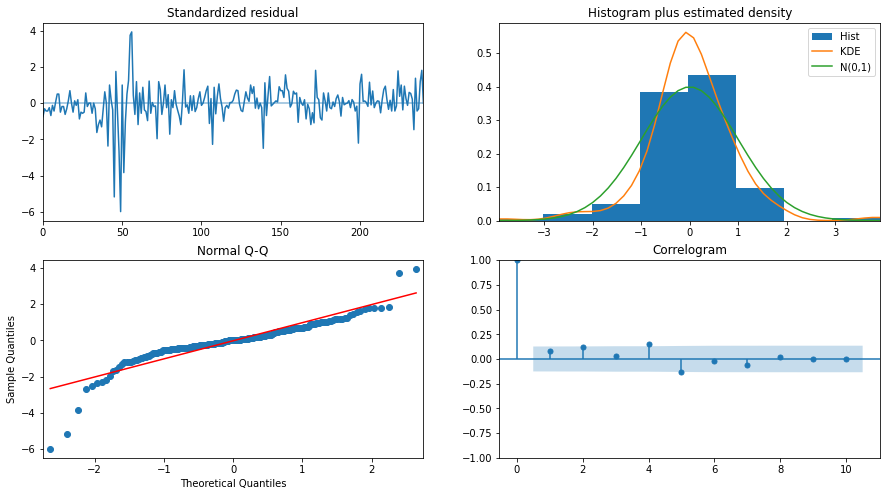

*****************************************************************************************************
*****************************************************************************************************
                                                                                                      
                                                                                                      
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=269.731, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=269.820, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=270.185, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=267.865, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=273.111, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.276 seconds
                               SARIM

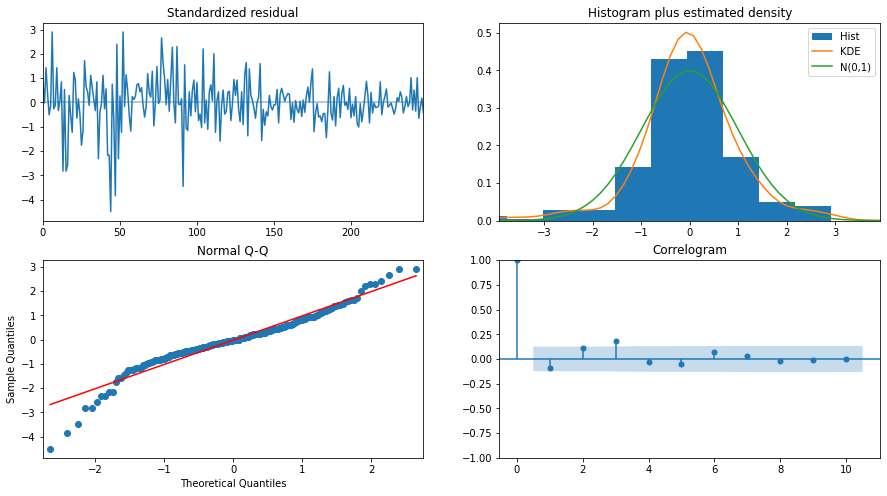

*****************************************************************************************************
*****************************************************************************************************
                                                                                                      
                                                                                                      
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1030.896, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1031.735, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1031.803, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1029.693, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1032.387, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.210 seconds
                              

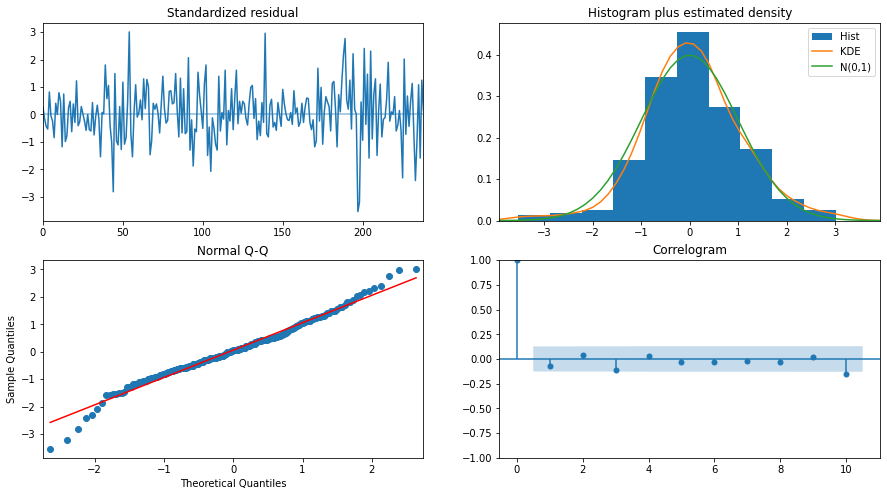

*****************************************************************************************************
*****************************************************************************************************
                                                                                                      
                                                                                                      
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3958.580, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3960.412, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3960.415, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3956.877, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3962.415, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.215 seconds
               

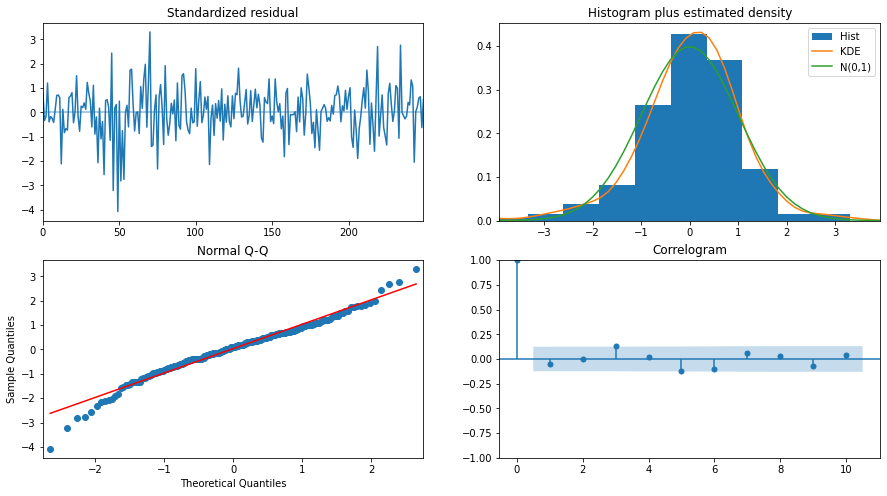

*****************************************************************************************************
*****************************************************************************************************
                                                                                                      
                                                                                                      


In [211]:
for f in csv_files:
      
    # read the csv file
    df_orig = pd.read_csv(f)
      
    # print the location and filename
    print('File Name:', f.split("\\")[-1])
      
    # print the content
#     print('Content:')
#     display(df_orig)
    
    data = hasnull(df_orig)
    data = covertype(data)
    data = removeMK(data,'Change %','Vol.')
    data = dateclean(data,'Date')
    data['Date'] = data['Date'].apply(str_to_datetime)
    data, data_train, data_test = splitdata_LSTM(data)
    selectpdq(data_train)
    print('*****************************************************************************************************')
    print('*****************************************************************************************************')
    print('                                                                                                      ')
    print('                                                                                                      ')
    

> **From the observation of selecting best model of p,d,q of Sarima, except Egypt selecting (1, 1, 0), the left country stock selecting (0,1,0)**

In [212]:
# remove Egypt sheet from the csv_file list
csv_files_new = csv_files.copy()
csv_files_new.pop(3)
print(csv_files_new)
print(csv_files)



['../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv', '../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv', '../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv', '../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Colombia - Cementos Argos SA (CCB).csv', '../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv', '../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv', '../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv']
['../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv', '../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv', '../input/valueinvestor/Vauleinvestor/2020Q1Q

In [213]:
for f in csv_files_new:
      
    # read the csv file
    df_orig = pd.read_csv(f)
      
    # print the location and filename
    print('File Name:', f.split("\\")[-1])
      
    # print the content
#     print('Content:')
#     display(df_orig)
    
    data = hasnull(df_orig)
    data = covertype(data)
    data = removeMK(data,'Change %','Vol.')
    data = dateclean(data,'Date')
    data['Date'] = data['Date'].apply(str_to_datetime)
    data, data_train, data_test = splitdata_LSTM(data)

    model=ARIMA(data_train,order=(0,1,0))
    model_fit=model.fit()
    print(model_fit.summary())
    prediction = model_fit.forecast(20)
    fc_series = pd.Series(prediction)
    predcition_1 = fc_series[:1]
    predcition_5 = fc_series[:5]
    predcition_20 = fc_series[:20]
    test_1 = data_test[:1]
    test_5 = data_test[:5]
    test_20 = data_test[:20]
    mae_Arima_daily = mean_absolute_error(test_1,predcition_1)
    mae_Arima_weekly = mean_absolute_error(test_5,predcition_5)
    mae_Arima_monthly = mean_absolute_error(test_20,predcition_20)
    print('Arima_daily MAE:{:.3f}'.format(mae_Arima_daily))
    print('Arima_weekly MAE:{:.3f}'.format(mae_Arima_weekly))
    print('Arima_monthlyMAE:{:.3f}'.format(mae_Arima_monthly))
    print('*****************************************************************************************************')
    print('*****************************************************************************************************')
    print('                                                                                                     ')
    print('                                                                                                     ')
    
    

File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  250
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -747.842
Date:                Sat, 24 Sep 2022   AIC                           1497.685
Time:                        17:20:30   BIC                           1501.202
Sample:                             0   HQIC                          1499.101
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        23.7810      1.267     18.772      0.000      21.298      26.264
Ljung-Box (L1) (Q):  

In [214]:
# predict Egpty stock price
data_Egypt = pd.read_csv('../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv')
data = hasnull(data_Egypt)
data = covertype(data)
data = removeMK(data,'Change %','Vol.')
data = dateclean(data,'Date')
data['Date'] = data['Date'].apply(str_to_datetime)
data, data_train, data_test = splitdata_LSTM(data)

model=ARIMA(data_train,order=(1,1,0))
model_fit=model.fit()
print(model_fit.summary())
prediction = model_fit.forecast(20)
fc_series = pd.Series(prediction)
predcition_1 = fc_series[:1]
predcition_5 = fc_series[:5]
predcition_20 = fc_series[:20]
test_1 = data_test[:1]
test_5 = data_test[:5]
test_20 = data_test[:20]
mae_Arima_daily = mean_absolute_error(test_1,predcition_1)
mae_Arima_weekly = mean_absolute_error(test_5,predcition_5)
mae_Arima_monthly = mean_absolute_error(test_20,predcition_20)
print('Arima_daily MAE:{:.3f}'.format(mae_Arima_daily))
print('Arima_weekly MAE:{:.3f}'.format(mae_Arima_weekly))
print('Arima_monthlyMAE:{:.3f}'.format(mae_Arima_monthly))

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  242
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 238.018
Date:                Sat, 24 Sep 2022   AIC                           -472.037
Time:                        17:20:31   BIC                           -465.067
Sample:                             0   HQIC                          -469.229
                                - 242                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2553      0.047      5.427      0.000       0.163       0.347
sigma2         0.0081      0.000     16.340      0.000       0.007       0.009
Ljung-Box (L1) (Q):                   0.09   Jarque-

# SARIMA

In [215]:
for f in csv_files_new:
      
    # read the csv file
    df_orig = pd.read_csv(f)
      
    # print the location and filename
    print('File Name:', f.split("\\")[-1])
      
    # print the content
#     print('Content:')
#     display(df_orig)
    
    data = hasnull(df_orig)
    data = covertype(data)
    data = removeMK(data,'Change %','Vol.')
    data = dateclean(data,'Date')
    data['Date'] = data['Date'].apply(str_to_datetime)
    data, data_train, data_test = splitdata_LSTM(data)
    model = sm.tsa.SARIMAX(data_train,order=(0,1,0),trend='c')
    result = model.fit(maxiter=1000,disp=False)
    print(result.summary())
    prediction = result.forecast(20)
    fc_series = pd.Series(prediction)
    predcition_1 = fc_series[:1]
    predcition_5 = fc_series[:5]
    predcition_20 = fc_series[:20]
    mae_Sarima_daily = mean_absolute_error(test_1,predcition_1)
    mae_Sarima_weekly = mean_absolute_error(test_5,predcition_5)
    mae_Sarima_monthly = mean_absolute_error(test_20,predcition_20)
    print('Sarima_daily MAE:{:.3f}'.format(mae_Sarima_daily))
    print('Sarima_weekly MAE:{:.3f}'.format(mae_Sarima_weekly))
    print('Sarima_monthly MAE:{:.3f}'.format(mae_Sarima_monthly))
    print('*****************************************************************************************************')
    print('*****************************************************************************************************')
    print('                                                                                                     ')
    print('                                                                                                     ')
    

File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  250
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -747.819
Date:                Sat, 24 Sep 2022   AIC                           1499.638
Time:                        17:20:31   BIC                           1506.673
Sample:                             0   HQIC                          1502.470
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0669      0.310      0.215      0.829      -0.542       0.675
sigma2        23.7766

In [216]:
# predict Egpty stock price
data_Egypt = pd.read_csv('../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv')
data = hasnull(data_Egypt)
data = covertype(data)
data = removeMK(data,'Change %','Vol.')
data = dateclean(data,'Date')
data['Date'] = data['Date'].apply(str_to_datetime)
data, data_train, data_test = splitdata_LSTM(data)
model = sm.tsa.SARIMAX(data_train,order=(0,1,0),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
prediction = result.forecast(20)
fc_series = pd.Series(prediction)
predcition_1 = fc_series[:1]
predcition_5 = fc_series[:5]
predcition_20 = fc_series[:20]
mae_Sarima_daily = mean_absolute_error(test_1,predcition_1)
mae_Sarima_weekly = mean_absolute_error(test_5,predcition_5)
mae_Sarima_monthly = mean_absolute_error(test_20,predcition_20)
print('Sarima_daily MAE:{:.3f}'.format(mae_Sarima_daily))
print('Sarima_weekly MAE:{:.3f}'.format(mae_Sarima_weekly))
print('Sarima_monthly MAE:{:.3f}'.format(mae_Sarima_monthly))

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  242
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 230.760
Date:                Sat, 24 Sep 2022   AIC                           -457.519
Time:                        17:20:32   BIC                           -450.549
Sample:                             0   HQIC                          -454.711
                                - 242                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0041      0.006     -0.657      0.511      -0.016       0.008
sigma2         0.0086      0.001     16.194      0.000       0.008       0.010
Ljung-Box (L1) (Q):                  13.52   Jarque-

# Analysis MAE of different model on different bais prediction

In [217]:
StockMAE = pd.read_csv('../input/stockmae/StockMAE.csv')
StockMAE

,coutry,model,daily predict,weekly predict,monthly predict
0,Russia,SVM,60.464,58.991,51.972
1,South Korea,SVM,3279.491,3246.923,2847.967
2,Turkey,SVM,5.664,5.929,5.430
3,Egypt,SVM,0.081,0.041,0.111
4,Colombia,SVM,1251.282,1249.972,1282.502
5,Brazil,SVM,4.261,3.03,2.044
6,Argentina,SVM,36.549,33.105,31.852
7,South Africa,SVM,5677.539,5871.544,6442.724
8,Russia,LSTM,270.961,271.592,274.403
9,South Korea,LSTM,7792.543,8505.943,8667.774


In [218]:
result_max = StockMAE.groupby(['model']).max()
result_max

,coutry,daily predict,weekly predict,monthly predict
model,,,,
ARIMA,Turkey,1639.000,934,1065.500
LSTM,Turkey,20310.682,8505.943,21254.724
SARIMA,Turkey,20008.710,:267.917,20223.754
SVM,Turkey,5677.539,5871.544,6442.724


In [219]:
result_min = StockMAE.groupby(['model']).min()
result_min

,coutry,daily predict,weekly predict,monthly predict
model,,,,
ARIMA,Brazil,0.095,0.095,0.126
LSTM,Brazil,3.567,10.183,3.688
SARIMA,Brazil,0.114,0.126,0.189
SVM,Brazil,0.081,0.041,0.111


# Calculate Bollinger Bands

In [220]:
#Calculate Simple Moving Average, Standard Deviation, Upper Band and the Lower Band
from pylab import mpl, plt
def PreCal(df,period):
    df = df.iloc[::-1]
    #Simple Moving Average
    df['SMA'] = df['Price'].rolling(window=period).mean()
    #Standard Deviation
    df['STD'] = df['Price'].rolling(window=period).std()
    #Upper Band
    df['Upper'] = df['SMA'] + (df['STD'] * 2)
    #Lower Band
    df['Lower'] = df['SMA'] - (df['STD'] * 2)
    return df['SMA'],df['STD'],df['Upper'], df['Lower']

In [221]:
def Previsualiztion(df):
    column_list = ['Price', 'SMA', 'Upper', 'Lower']
    df[column_list].plot(figsize=(12.2,6.4))
    plt.title('Bollinger Band for Stock')
    plt.ylabel('Price')
    plt.show()
    
    fig = plt.figure(figsize=(12.2, 6.4))
    ax = fig.add_subplot(1,1,1)
    x_axis = data.index
    ax.fill_between(x_axis, df['Upper'], df['Lower'], color = 'grey')
    ax.plot(x_axis, df['Price'], color = 'red', lw = 3, label = 'Price')
    ax.plot(x_axis, df['SMA'], color = 'blue', lw = 3, label = 'Simple Moving Average')
    ax.set_title('Bollinger Band for Stock')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.xticks(rotation = 45)
    ax.legend()
    plt.show()
    

In [222]:
def get_signal(df):
    buy_signal = []
    sell_signal = []
    
    for i in range(len(df['Price'])):
        if df['Price'].values[i] > df['Upper'].values[i]:
            buy_signal.append(np.nan)
            sell_signal.append(data['Price'].values[i])
        elif df['Price'].values[i] < df['Lower'].values[i]:
            buy_signal.append(df['Price'].values[i])
            sell_signal.append(np.nan)
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
        
    return(buy_signal, sell_signal)

In [223]:
def statusvisualization(df):
    new_df = df[period-1:]
    new_df['Buy'] = get_signal(new_df)[0]
    new_df['Sell'] = get_signal(new_df)[1]
    fig = plt.figure(figsize=(12.2, 6.4))
    ax = fig.add_subplot(1,1,1)
    x_axis = new_df.index
    ax.fill_between(x_axis, new_df['Upper'], new_df['Lower'], color = 'grey')
    ax.plot(x_axis, new_df['Price'], color = 'gold', lw = 3, label = 'Closing Price', alpha = 0.35)
    ax.plot(x_axis, new_df['SMA'], color = 'blue', lw = 3, label = 'Simple Moving Average', alpha = 0.35)
    ax.scatter(x_axis, new_df['Buy'], color = 'green', lw = 3, label = 'Buy', marker = "^", alpha = 0.35)
    ax.scatter(x_axis, new_df['Sell'], color = 'red', lw = 3, label = 'Sell', marker = "v", alpha = 0.35)
    ax.set_title('Buy, hold  or Sell Bollinger Band for Stock')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.xticks(rotation = 45)
    ax.legend()
    plt.show()

File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv


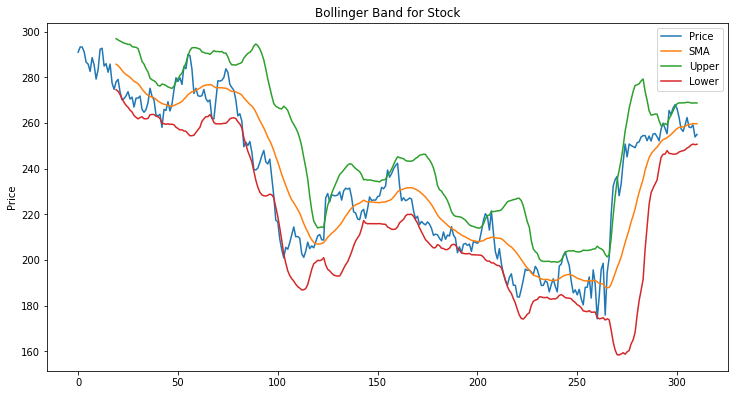

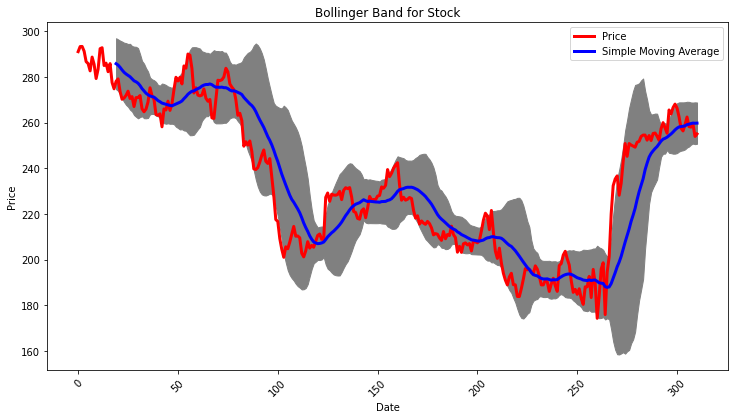

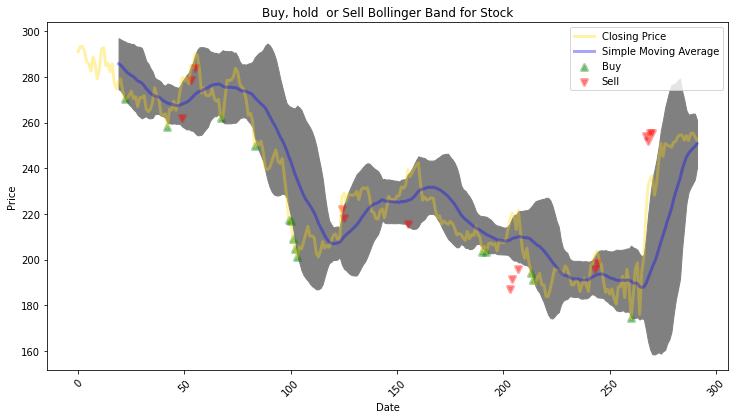

File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv


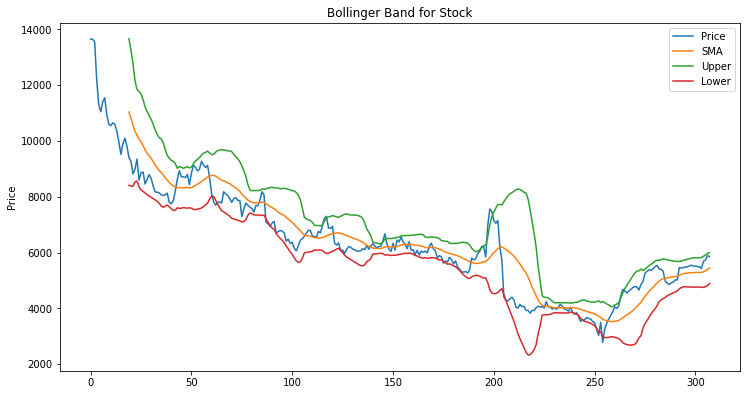

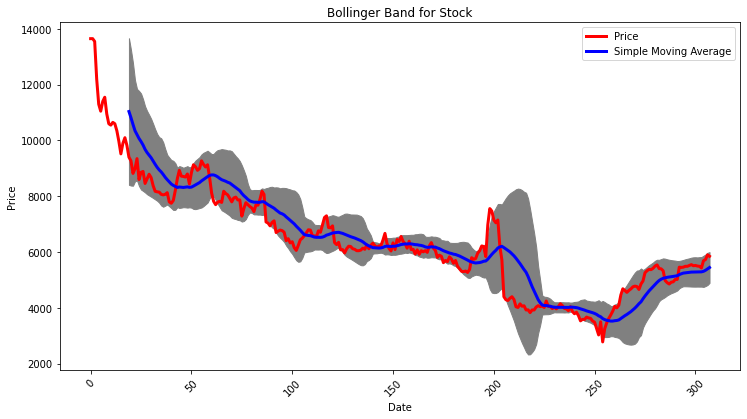

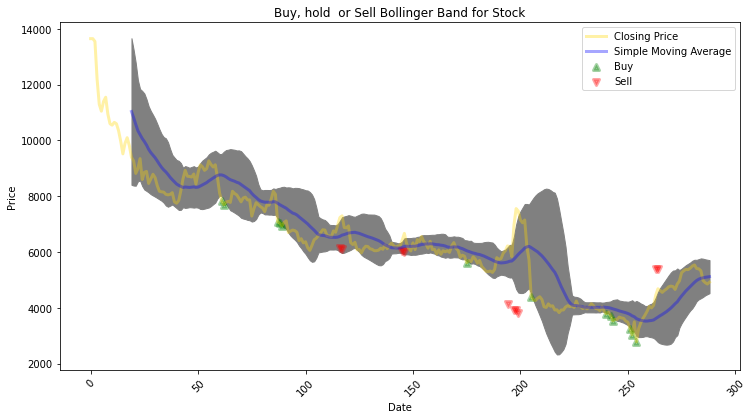

File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv


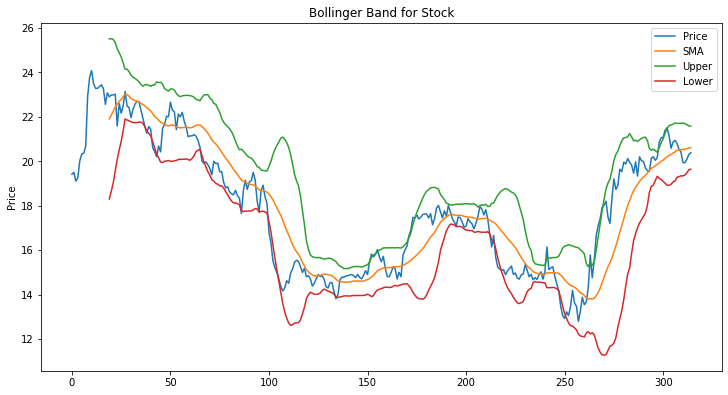

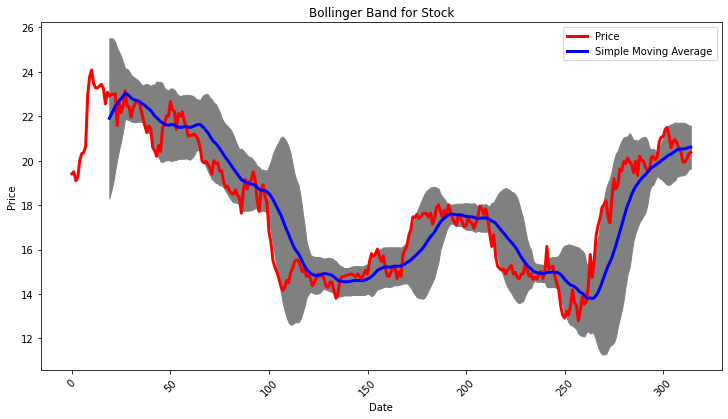

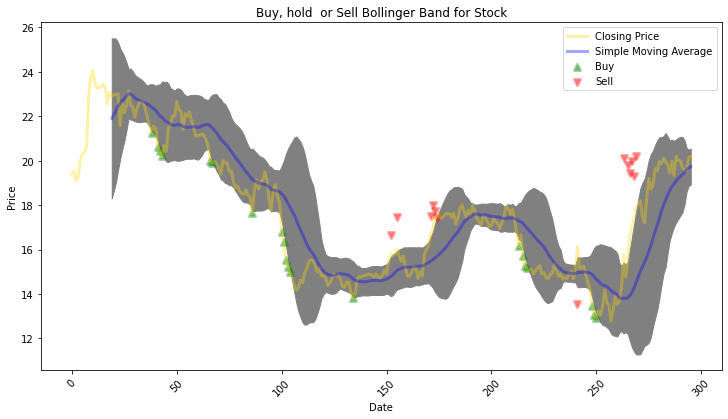

File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv


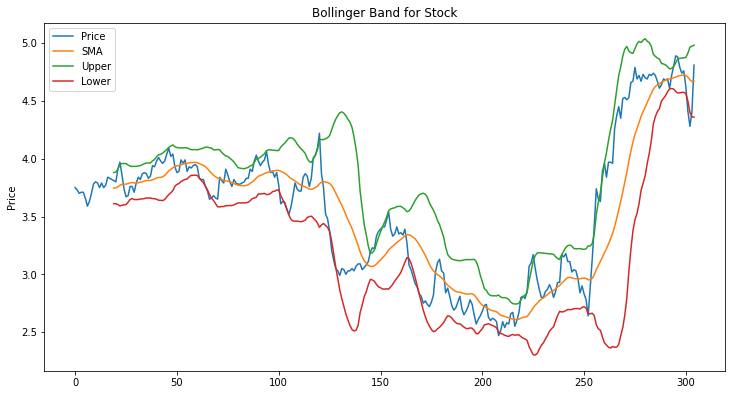

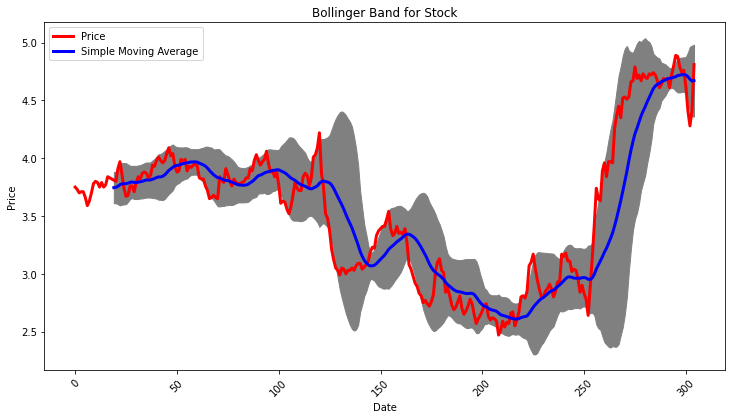

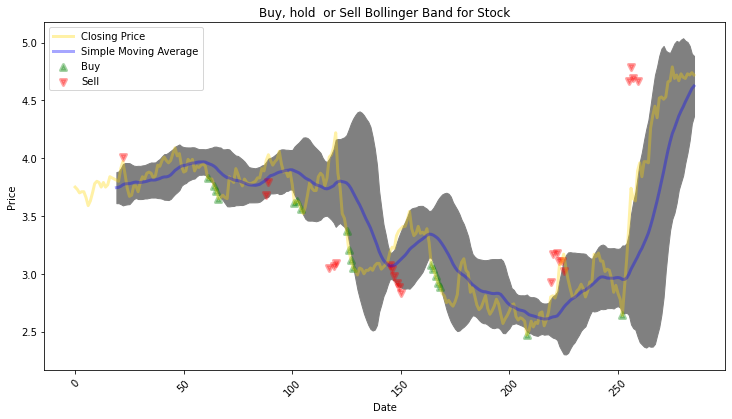

File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Colombia - Cementos Argos SA (CCB).csv


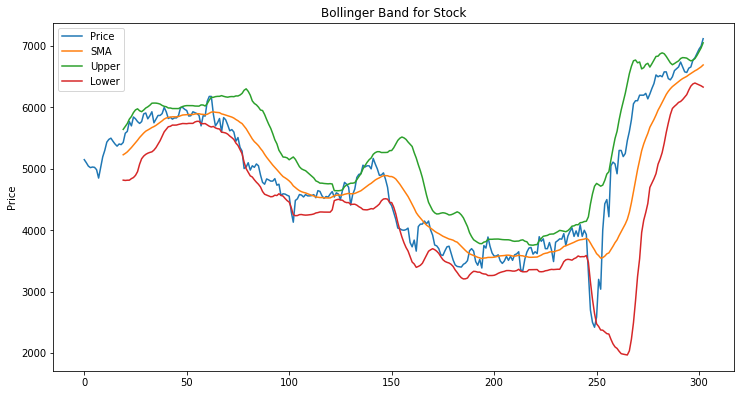

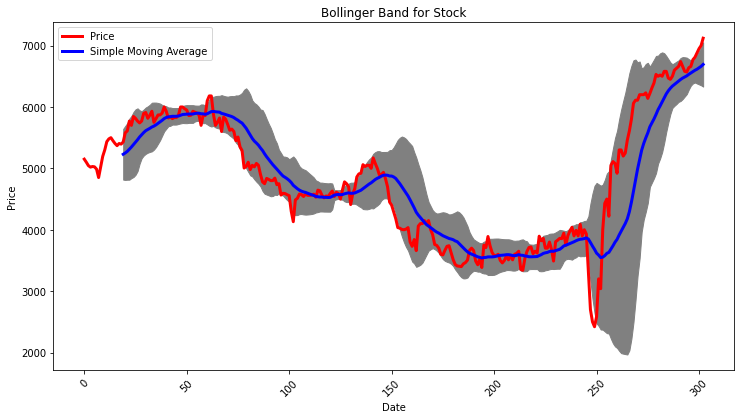

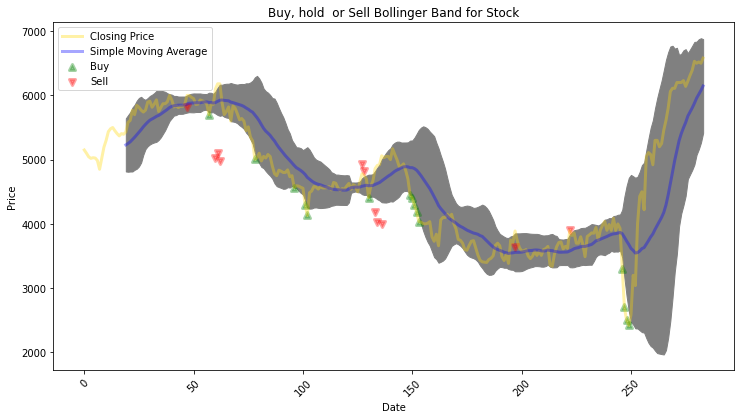

File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv


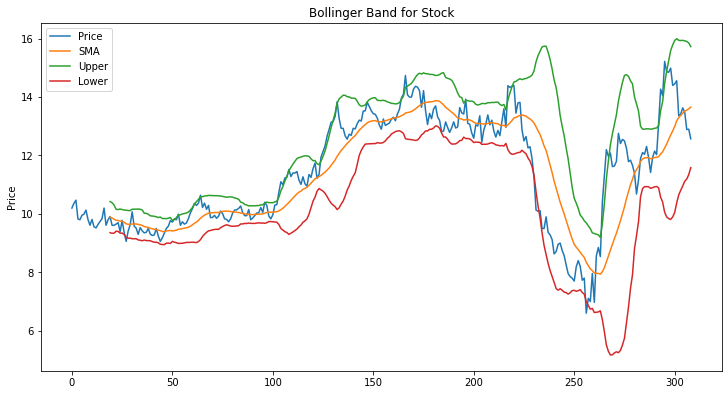

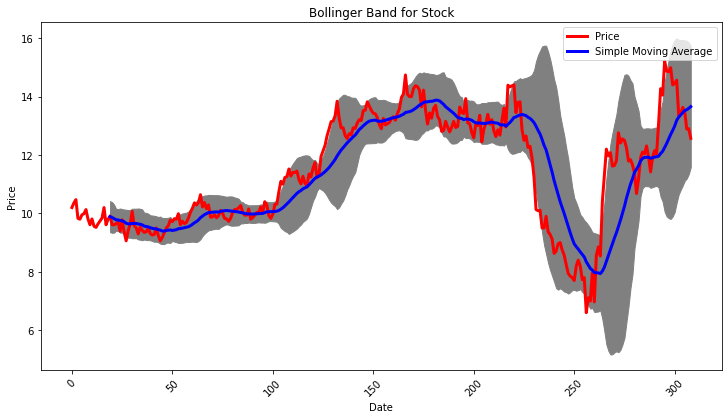

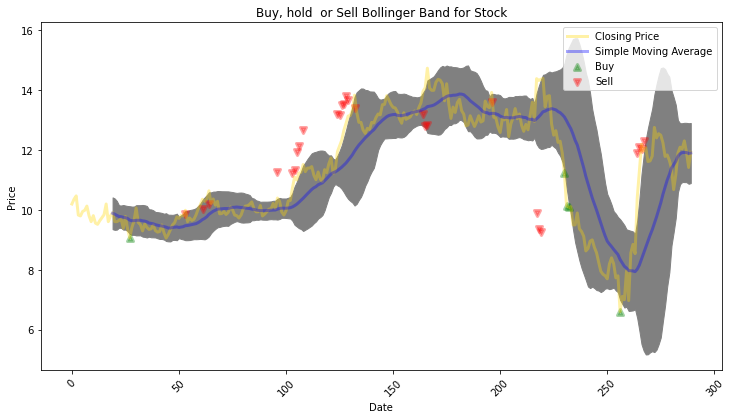

File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv


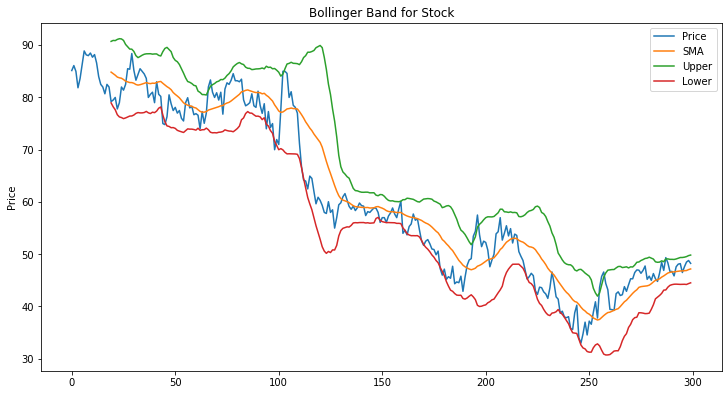

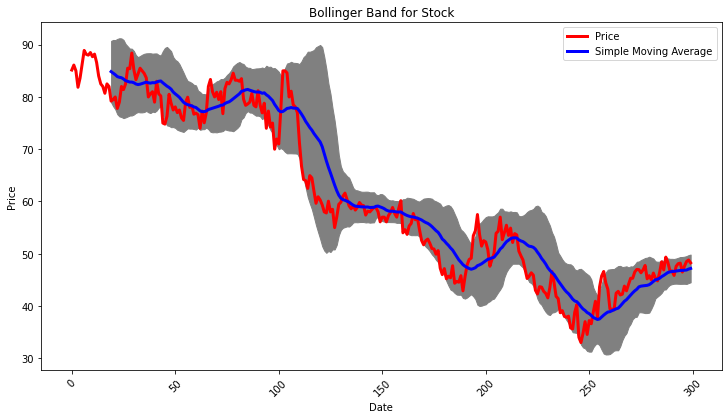

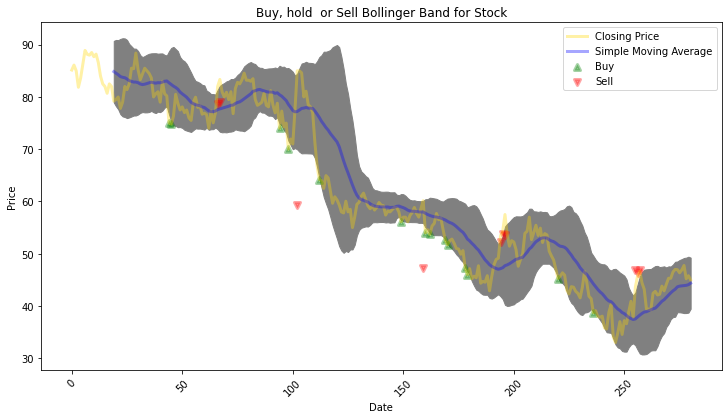

File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv


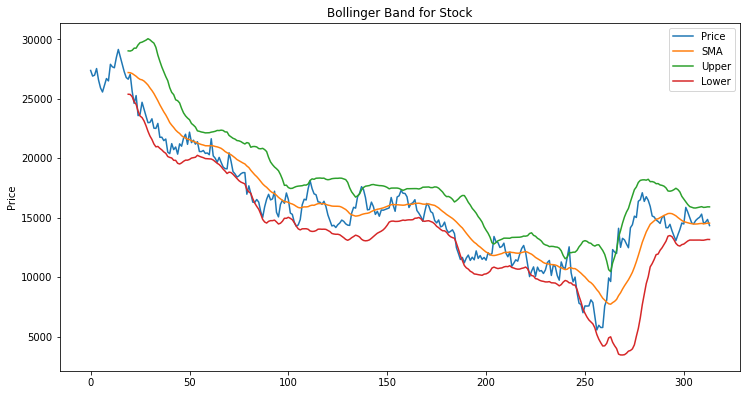

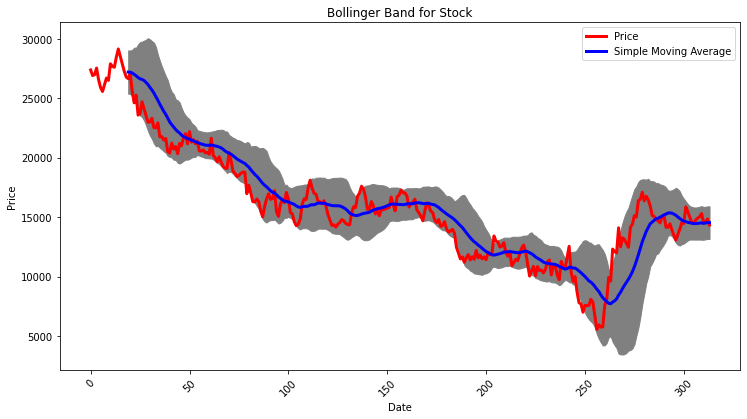

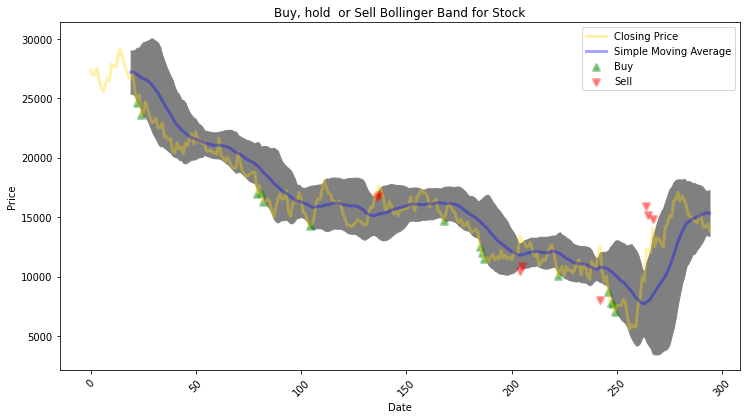

In [224]:
for f in csv_files:
      
    # read the csv file
    df_orig = pd.read_csv(f)
      
    # print the location and filename
    print('File Name:', f.split("\\")[-1])
      
    # print the content
#     print('Content:')
#     display(df_orig)
    
    data = hasnull(df_orig)
    data = covertype(data)
    data = removeMK(data,'Change %','Vol.')
    data = dateclean(data,'Date')
    data['Date'] = data['Date'].apply(str_to_datetime)
    period = 20
    data['SMA'],data['STD'],data['Upper'], data['Lower'] = PreCal(data,period)
    Previsualiztion(data)
    statusvisualization(data)
    

# Caculate the Capital return

In [225]:
def Capitalreturn(df,period):
    new_df = df[period-1:]
    new_df['Buy'] = get_signal(new_df)[0]
    new_df['Sell'] = get_signal(new_df)[1]
    new_df_1 = new_df.copy()
    new_df_1 = new_df_1.dropna(subset=['Buy'])
    new_df_2 = new_df.copy()
    new_df_2 = new_df_2.dropna(subset=['Sell'])
    new_df_2['Sell'] = new_df_2['Sell'].astype('float')
    sum_buy = 0
    sum_sell = 0
    for i in range(len(new_df_1['Buy'])):
        sum_buy -= new_df_1['Buy'].values[i]
    #     print(sum_buy)
    for i in range(len(new_df_2['Sell'])):
        sum_sell += new_df_2['Sell'].values[i]
    #     print(sum_sell)
    Profit = sum_sell+sum_buy
    if Profit > 0:
        print('The Captial Return is {:.2f}'.format(Profit))
    elif Profit < 0:
        print('The Captial Loss is {:.2f}'.format(Profit))
    else: 0 
    print('                                                                                       ')
    print('                                                                                       ')

In [226]:
for f in csv_files:
      
    # read the csv file
    df_orig = pd.read_csv(f)
      
    # print the location and filename
    print('File Name:', f.split("\\")[-1])
      
    # print the content
#     print('Content:')
#     display(df_orig)
    
    data = hasnull(df_orig)
    data = covertype(data)
    data = removeMK(data,'Change %','Vol.')
    data = dateclean(data,'Date')
    data['Date'] = data['Date'].apply(str_to_datetime)
    period = 20
    data['SMA'],data['STD'],data['Upper'], data['Lower'] = PreCal(data,period)
    Capitalreturn(data,period)

File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv
The Captial Return is 411.55
                                                                                       
                                                                                       
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv
The Captial Loss is -15775.00
                                                                                       
                                                                                       
File Name: ../input/valueinvestor/Vauleinvestor/2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv
The Captial Loss is -97.14
                                                                                       
                                                                                       
File Name: ../input/valueinvestor/Vauleinvestor